## Judge LLM.

This is the second file you will run.

First execute COT_modelname_ollama.ipynb file

In [6]:
import json
import re
import time
from statistics import mean, stdev
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
!pip install langchain langchain-community


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
!pip install langchain tqdm nest_asyncio matplotlib pandas

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
from langchain_community.chat_models import ChatOllama
from langchain.schema import SystemMessage, HumanMessage




Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

C:\Users\PC\AppData\Local\Temp\ipykernel_21672\3686551730.py:34: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  llm = ChatOllama(
Evaluating: 100%|██████████| 21/21 [06:55<00:00, 19.79s/it]

Appended partial results after 21 entries.

CSV exported to: Llama3_CodeQA_llm_as_judge.csv


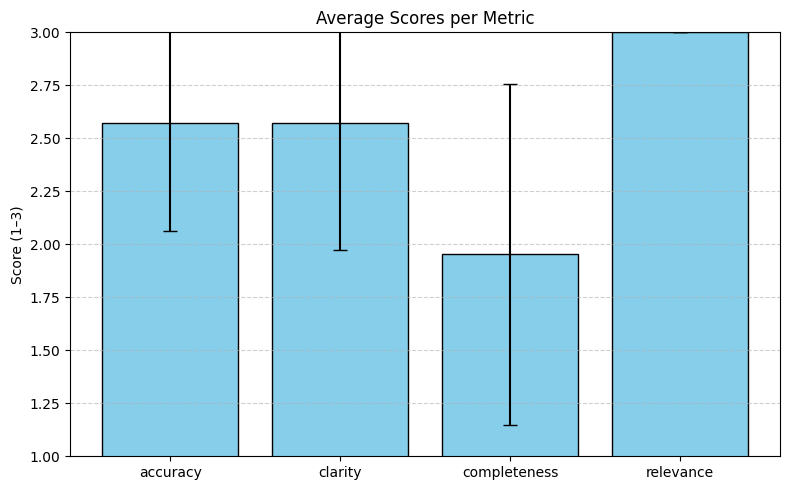

In [11]:
import json
import asyncio
from concurrent.futures import ThreadPoolExecutor
from tqdm.asyncio import tqdm_asyncio
import pandas as pd
import matplotlib.pyplot as plt
from langchain.schema import SystemMessage, HumanMessage
from langchain_community.chat_models import ChatOllama  # or your import path

executor = ThreadPoolExecutor(max_workers=5)  # tune concurrency


def save_json_data_append(path, new_data):
    """
    Load existing data from path, append new_data (list of dict),
    then save combined data back to path.
    """
    try:
        with open(path, 'r', encoding='utf-8') as f:
            existing_data = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        existing_data = []

    # Combine and deduplicate by "id" if present, else just append
    existing_ids = {item.get("id") for item in existing_data if "id" in item}
    filtered_new = [item for item in new_data if item.get("id") not in existing_ids]
    combined = existing_data + filtered_new

    with open(path, 'w', encoding='utf-8') as f:
        json.dump(combined, f, indent=2, ensure_ascii=False)


async def call_llm_LangChain_correct_v2_async(prompt, temperature=0.0):
    llm = ChatOllama(
        model="llama3.1:8b",
        temperature=temperature
    )

    system_prompt = """
You are an expert system to assess the quality of code comprehension by an LLM. 
You will receive:
- A Python code snippet
- A programming question about that code
- A reference (correct) answer
- A model-generated answer (prediction)

Your task is to evaluate the prediction against the reference answer using four metrics:
accuracy, completeness, relevance, and clarity. For each, provide:
- An integer score from 1 to 3

### Accuracy
Compare the prediction with the reference to assess factual correctness and understanding of the code’s behavior and intent.
You must judge whether the prediction reflects accurate behavior and matches core facts from the reference. 
You need to consider semantic meaning of code comprehension: understanding the structure, functionality, and intent behind the code.

Score meanings:
- 1: Completely incorrect or irrelevant; does not address the reference answer.
- 2: Partially correct; some key facts are accurate, but major details are wrong or missing.
- 3: Fully correct; matches the reference answer in meaning and factual content.

### Completeness
Check if the prediction covers all important parts of the reference answer, including key concepts or conditions.

Score meanings:
- 1: Omits most key information or contains only a tiny fragment of relevant content.
- 2: Covers some elements but misses important parts.
- 3: Fully covers all essential information from the reference.

### Relevance
Assess whether the prediction directly addresses the question and stays on-topic.

Score meanings:
- 1: Completely irrelevant or mostly unrelated.
- 2: Partially related but misses the main point.
- 3: Fully focused and directly answers the question.

### Clarity
Evaluate how clearly and logically the prediction is expressed, ensuring it is easy to understand.

Score meanings:
- 1: Confusing, vague, or incoherent.
- 2: Understandable but awkwardly phrased or slightly unclear.
- 3: Clear, concise, and easy to follow.

Example:

{
  "Code": "def aggregate metadata get by host context host key None return IMPL aggregate metadata get by host context host key",
  "Question": "What does the code get ?",
  "Reference Answer": "metadata for all aggregates that host belongs to",
  "Model Answer": "Hosts",
  "Evaluation": {
    "accuracy": { "score": 1 },
    "completeness": { "score": 1 },
    "relevance": { "score": 2 },
    "clarity": { "score": 3 }
  }
}

Final Instructions:
Base your evaluation strictly on the content provided. Do not hallucinate missing information. Be consistent and objective.
Provide evaluation only in integer score only for each dimension.
Respond only with a JSON object in this exact format:
{
"accuracy": { "score": 1-3 },
"completeness": { "score": 1-3 },
"relevance": { "score": 1-3 },
"clarity": { "score": 1-3 }
}
"""

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=prompt)
    ]

    loop = asyncio.get_running_loop()
    response = await loop.run_in_executor(executor, lambda: llm.invoke(messages))
    return response.content


def make_llm_eval_prompt(code, question, reference, prediction):
    return f"""
Code:
{code}

Question:
{question}

Reference Answer:
{reference}

Model Answer:
{prediction}
"""


def extract_all_scores(response_text):
    import json
    try:
        parsed = json.loads(response_text)
    except json.JSONDecodeError:
        return {}

    results = {}
    for metric, details in parsed.items():
        if isinstance(details, dict):
            score = details.get("score")
            if isinstance(score, int):
                results[metric] = {"score": score}
    return results


async def evaluate_batch_async(data, save_every=25, output_path="CodeLlama_llm_as_judge.json"):
    results = []
    flat_records = []

    for i, item in enumerate(tqdm_asyncio(data, desc="Evaluating")):
        code = item["code"]
        question = item["question"]
        reference = item["answer"]
        prediction = item["prediction"]
        q_id = item.get("id", f"q{i+1}")

        prompt = make_llm_eval_prompt(code, question, reference, prediction)
        try:
            response = await call_llm_LangChain_correct_v2_async(prompt)
            metric_results = extract_all_scores(response)
        except Exception as e:
            print(f"Error evaluating entry {i+1}: {e}")
            metric_results = {}

        sample_result = {
            "id": q_id,
            "code": code,
            "question": question,
            "reference":reference,
            "prediction": prediction,
        }

        for metric in ["accuracy", "completeness", "relevance", "clarity"]:
            score = metric_results.get(metric, {}).get("score", None)
            sample_result[metric] = {"score": score}
            flat_records.append({
                "id": q_id,
                "code": code,
                "question": question,
                "reference":reference,
                "prediction": prediction,
                "metric": metric,
                "score": score,
            })

        results.append(sample_result)

        if (i + 1) % save_every == 0 or (i + 1) == len(data):
            try:
                save_json_data_append(output_path, results)
                print(f"Appended partial results after {i + 1} entries.")
                results = []  # clear buffer after saving
            except Exception as e:
                print(f"Warning: Failed to save at entry {i + 1}: {str(e)}")

    return results, flat_records


def export_csv(flat_records, path):
    df = pd.DataFrame(flat_records)
    df.to_csv(path, index=False)
    print(f"\nCSV exported to: {path}")


def visualize_scores(flat_records):
    df = pd.DataFrame(flat_records)
    if 'score' not in df.columns or 'metric' not in df.columns:
        raise ValueError("Expected 'score' and 'metric' columns in flat_records.")

    grouped = df.groupby("metric")["score"]
    avg_scores = grouped.mean()
    std_scores = grouped.std().fillna(0)

    plt.figure(figsize=(8, 5))
    plt.bar(
        avg_scores.index,
        avg_scores.values,
        yerr=std_scores.values,
        capsize=5,
        color='skyblue',
        edgecolor='black'
    )
    plt.title("Average Scores per Metric")
    plt.ylabel("Score (1–3)")
    plt.ylim(1, 3)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    import nest_asyncio
    nest_asyncio.apply()

    with open("predictions.json", "r", encoding="utf-8") as f:
        dataset = json.load(f)

    output_json_path = "Llama3_CodeQA_llm_as_judge.json"
    output_csv_path = "Llama3_CodeQA_llm_as_judge.csv"

    results, flat_records = asyncio.run(evaluate_batch_async(dataset, save_every=25, output_path=output_json_path))

    # Save any leftover results after loop
    if results:
        save_json_data_append(output_json_path, results)

    export_csv(flat_records, path=output_csv_path)
    visualize_scores(flat_records)
